<a href="https://colab.research.google.com/github/fjadidi2001/Denoise/blob/main/Decom_May19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: Environment Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision # Explicitly import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from tqdm import tqdm
import gdown

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install torch torchvision torchaudio
!pip install scikit-image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directory for dataset
os.makedirs('/content/dataset', exist_ok=True)

# Output: Table of installed packages
packages = ['torch', 'torchvision', 'scikit-image']
versions = [torch.__version__, torchvision.__version__, 'scikit-image']
pd.DataFrame({'Package': packages, 'Version': versions}).style.set_caption("Installed Packages")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


,Package,Version
0,torch,2.6.0+cu124
1,torchvision,0.21.0+cu124
2,scikit-image,scikit-image


In [3]:
# Cell 2: Model Definition
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss  # Import _Loss explicitly

class sum_squared_error(_Loss):
    def __init__(self, reduction='sum'):
        super(sum_squared_error, self).__init__(reduction=reduction)

    def forward(self, input, target):
        return torch.nn.functional.mse_loss(input, target, reduction='sum').div_(2)

class UNet_Atten_3(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet_Atten_3, self).__init__()
        # Encoder and Decoder blocks
        self._block1_dw = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block2_dw = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block3_dw = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
        self._block4_dw = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block5_dw = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block6_dw = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self._block1_dw2 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block2_dw2 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block3_dw2 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
        self._block4_dw2 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block5_dw2 = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block6_dw2 = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self._block1_dn = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block2_dn = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block3_dn = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
        self._block4_dn = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block5_dn = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block6_dn = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self._block1_wm = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block2_wm = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block3_wm = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
        self._block4_wm = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block5_wm = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block6_wm = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self.avg_dn = nn.AdaptiveAvgPool2d((1, 1))
        self.attn_dn = nn.Sequential(
            nn.Conv2d(144, 6, kernel_size=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 144, kernel_size=1, stride=1),
            nn.Sigmoid())
        self.avg_wm = nn.AdaptiveAvgPool2d((1, 1))
        self.attn_wm = nn.Sequential(
            nn.Conv2d(144, 6, kernel_size=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 144, kernel_size=1, stride=1),
            nn.Sigmoid())
        self.out = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        pool1_dn = self._block1_dn(x)
        pool2_dn = self._block2_dn(pool1_dn)
        pool3_dn = self._block2_dn(pool2_dn)
        pool4_dn = self._block2_dn(pool3_dn)
        pool5_dn = self._block2_dn(pool4_dn)
        upsample5_dn = self._block3_dn(pool5_dn)
        concat5_dn = torch.cat((upsample5_dn, pool4_dn), dim=1)
        upsample4_dn = self._block4_dn(concat5_dn)
        concat4_dn = torch.cat((upsample4_dn, pool3_dn), dim=1)
        upsample3_dn = self._block5_dn(concat4_dn)
        concat3_dn = torch.cat((upsample3_dn, pool2_dn), dim=1)
        upsample2_dn = self._block5_dn(concat3_dn)
        concat2_dn = torch.cat((upsample2_dn, pool1_dn), dim=1)
        upsample1_dn = self._block5_dn(concat2_dn)
        concat1_dn = torch.cat((upsample1_dn, x), dim=1)
        out_denoise = self._block6_dn(concat1_dn)
        pool1_wm = self._block1_wm(out_denoise)
        pool2_wm = self._block2_wm(pool1_wm)
        pool3_wm = self._block2_wm(pool2_wm)
        pool4_wm = self._block2_wm(pool3_wm)
        pool5_wm = self._block2_wm(pool4_wm)
        upsample5_wm = self._block3_wm(pool5_wm)
        concat5_wm = torch.cat((upsample5_wm, pool4_wm), dim=1)
        upsample4_wm = self._block4_wm(concat5_wm)
        concat4_wm = torch.cat((upsample4_wm, pool3_wm), dim=1)
        upsample3_wm = self._block5_wm(concat4_wm)
        concat3_wm = torch.cat((upsample3_wm, pool2_wm), dim=1)
        upsample2_wm = self._block5_wm(concat3_wm)
        concat2_wm = torch.cat((upsample2_wm, pool1_wm), dim=1)
        upsample1_wm = self._block5_wm(concat2_wm)
        concat1_wm = torch.cat((upsample1_wm, x), dim=1)
        out_wm = self._block6_wm(concat1_wm)
        pool1_dw = self._block1_dw(x)
        pool2_dw = self._block2_dw(pool1_dw)
        pool3_dw = self._block2_dw(pool2_dw)
        pool4_dw = self._block2_dw(pool3_dw)
        pool5_dw = self._block2_dw(pool4_dw)
        upsample5_dw = self._block3_dw(pool5_dw)
        concat5_dw = torch.cat((upsample5_dw, pool4_dw), dim=1)
        upsample4_dw = self._block4_dw(concat5_dw)
        concat4_dw = torch.cat((upsample4_dw, pool3_dw), dim=1)
        upsample3_dw = self._block5_dw(concat4_dw)
        concat3_dw = torch.cat((upsample3_dw, pool2_dw), dim=1)
        upsample2_dw = self._block5_dw(concat3_dw)
        concat2_dw = torch.cat((upsample2_dw, pool1_dw), dim=1)
        mid_dn = self.avg_dn(concat2_dn)
        Scale_dn = self.attn_dn(mid_dn)
        concat2_dw = concat2_dw * Scale_dn
        upsample1_dw = self._block5_dw(concat2_dw)
        concat1_dw = torch.cat((upsample1_dw, x), dim=1)
        main_out_mid = self._block6_dw(concat1_dw)
        pool1_dw2 = self._block1_dw2(main_out_mid)
        pool2_dw2 = self._block2_dw2(pool1_dw2)
        pool3_dw2 = self._block2_dw2(pool2_dw2)
        pool4_dw2 = self._block2_dw(pool3_dw2)
        pool5_dw2 = self._block2_dw(pool4_dw2)
        upsample5_dw2 = self._block3_dw(pool5_dw2)
        concat5_dw2 = torch.cat((upsample5_dw2, pool4_dw2), dim=1)
        upsample4_dw2 = self._block4_dw(concat5_dw2)
        concat4_dw2 = torch.cat((upsample4_dw2, pool3_dw2), dim=1)
        upsample3_dw2 = self._block5_dw(concat4_dw2)
        concat3_dw2 = torch.cat((upsample3_dw2, pool2_dw2), dim=1)
        upsample2_dw2 = self._block5_dw(concat3_dw2)
        concat2_dw2 = torch.cat((upsample2_dw2, pool1_dw2), dim=1)
        mid_wm = self.avg_wm(concat2_wm)
        Scale_wm = self.attn_wm(mid_wm)
        concat2_dw2 = concat2_dw2 * Scale_wm
        upsample1_dw2 = self._block5_dw2(concat2_dw2)
        concat1_dw2 = torch.cat((upsample1_dw2, x), dim=1)
        main_out_final = self._block6_dw2(concat1_dw2)
        return main_out_final, out_denoise, out_wm

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet_Atten_3().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Output: Table of model summary
import pandas as pd
data = {'Component': ['Total Parameters'], 'Count': [total_params]}
pd.DataFrame(data).style.set_caption("Model Summary")

Total parameters: 2806365


,Component,Count
0,Total Parameters,2806365


Dataset loaded successfully


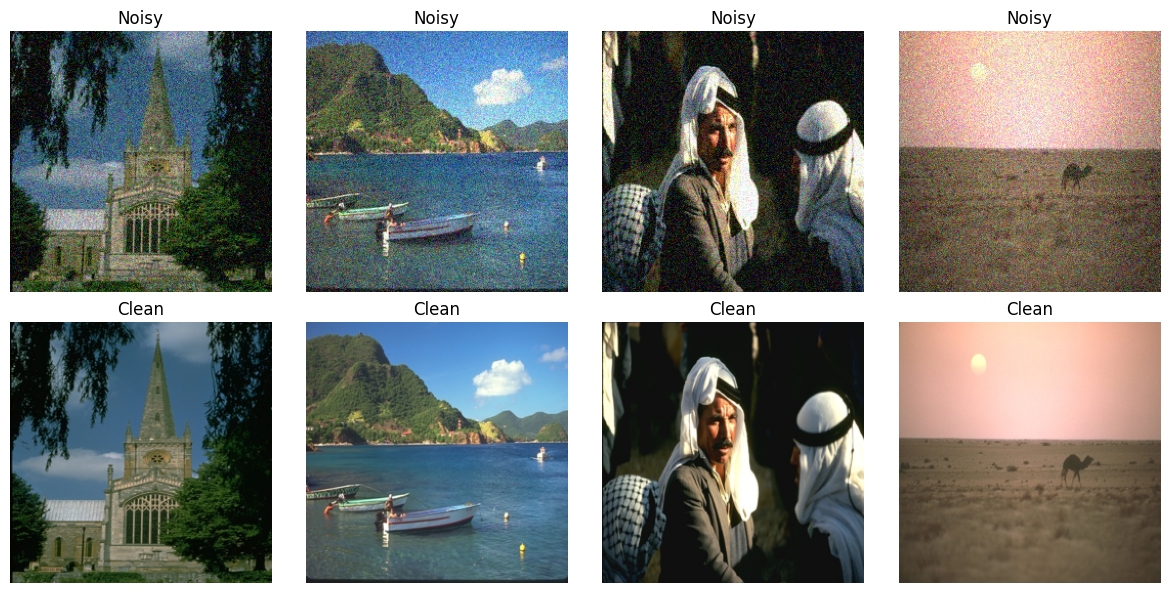

,Dataset,Number of Images
0,Train,200
1,Validation,100


In [4]:
# Cell 3: Dataset Preparation
class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, noise_level=25):
        self.root_dir = os.path.join(root_dir, 'BSR/BSDS500/data/images', mode)
        self.transform = transform
        self.noise_level = noise_level
        self.images = [os.path.join(self.root_dir, img) for img in os.listdir(self.root_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Add Gaussian noise
        noise = torch.randn_like(image) * (self.noise_level / 255.0)
        noisy_image = image + noise
        noisy_image = torch.clamp(noisy_image, 0, 1)
        return noisy_image, image

# Download and extract BSDS500
try:
    if not os.path.exists('/content/dataset/BSR_bsds500.tgz'):
        !wget -P /content/dataset https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
    if not os.path.exists('/content/dataset/BSR'):
        !tar -xzf /content/dataset/BSR_bsds500.tgz -C /content/dataset
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = BSDS500Dataset(root_dir='/content/dataset', mode='train', transform=transform)
val_dataset = BSDS500Dataset(root_dir='/content/dataset', mode='val', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# Visualize sample images
noisy, clean = next(iter(train_loader))
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(noisy[i].permute(1, 2, 0).numpy())
    axes[0, i].set_title('Noisy')
    axes[1, i].imshow(clean[i].permute(1, 2, 0).numpy())
    axes[1, i].set_title('Clean')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

# Output: Table of dataset statistics
data = {
    'Dataset': ['Train', 'Validation'],
    'Number of Images': [len(train_dataset), len(val_dataset)]
}
pd.DataFrame(data).style.set_caption("Dataset Statistics")

In [ ]:
# Cell 4: Model Training
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import gc
from skimage.metrics import structural_similarity as ssim

# Define a combined MSE + SSIM loss
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.alpha = alpha

    def forward(self, pred, target):
        mse = self.mse_loss(pred, target)
        # Convert to numpy for SSIM calculation
        pred_np = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
        target_np = target.detach().cpu().numpy().transpose(0, 2, 3, 1)
        ssim_val = 0
        for i in range(pred_np.shape[0]):
            s = ssim(target_np[i], pred_np[i], win_size=7, channel_axis=-1, data_range=1.0)
            ssim_val += s
        ssim_val = 1 - (ssim_val / pred_np.shape[0])  # Convert to loss (1 - SSIM)
        return self.alpha * mse + (1 - self.alpha) * ssim_val

# Ensure model and data loaders are defined (from previous steps)
criterion = CombinedLoss(alpha=0.5)  # Balance between MSE and SSIM
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50  # Increased for better convergence
batch_size = 4
accumulation_steps = 2

# Update data loaders with batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    for i, (noisy, clean) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        noisy, clean = noisy.to(device), clean.to(device)
        main_out, _, _ = model(noisy)
        main_out = torch.clamp(main_out, 0, 1)  # Ensure output is in [0, 1]
        loss = criterion(main_out, clean) / accumulation_steps
        loss.backward()
        train_loss += loss.item() * accumulation_steps * noisy.size(0)

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Clear memory
        del noisy, clean, main_out, loss
        torch.cuda.empty_cache()
        gc.collect()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            main_out, _, _ = model(noisy)
            main_out = torch.clamp(main_out, 0, 1)
            loss = criterion(main_out, clean)
            val_loss += loss.item() * noisy.size(0)
            del noisy, clean, main_out, loss
            torch.cuda.empty_cache()
            gc.collect()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save model checkpoint
    torch.save(model.state_dict(), f'/content/drive/MyDrive/ssnet_model_epoch_{epoch+1}.pth')

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Lightweight Denoising')
plt.legend()
plt.show()

# Output: Table of losses
data = {
    'Epoch': list(range(1, num_epochs + 1)),
    'Train Loss': [f'{x:.4f}' for x in train_losses],
    'Validation Loss': [f'{x:.4f}' for x in val_losses]
}
pd.DataFrame(data).style.set_caption("Training and Validation Losses")

Epoch 1/50: 100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


Image 0 shape: (256, 256, 3)
Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 0 shape: (256, 256, 3)
Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 0 shape: (256, 256, 3)
Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 0 shape: (256, 256, 3)
Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 0 shape: (256, 256, 3)
Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 0 shape: (256, 256, 3)
Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 0 shape: (256, 256, 3)
Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 0 shape: (256, 256, 3)
Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 0 shape: (256, 256, 3)
Image 1 shape: (256, 256, 3)
Image 2 shape:

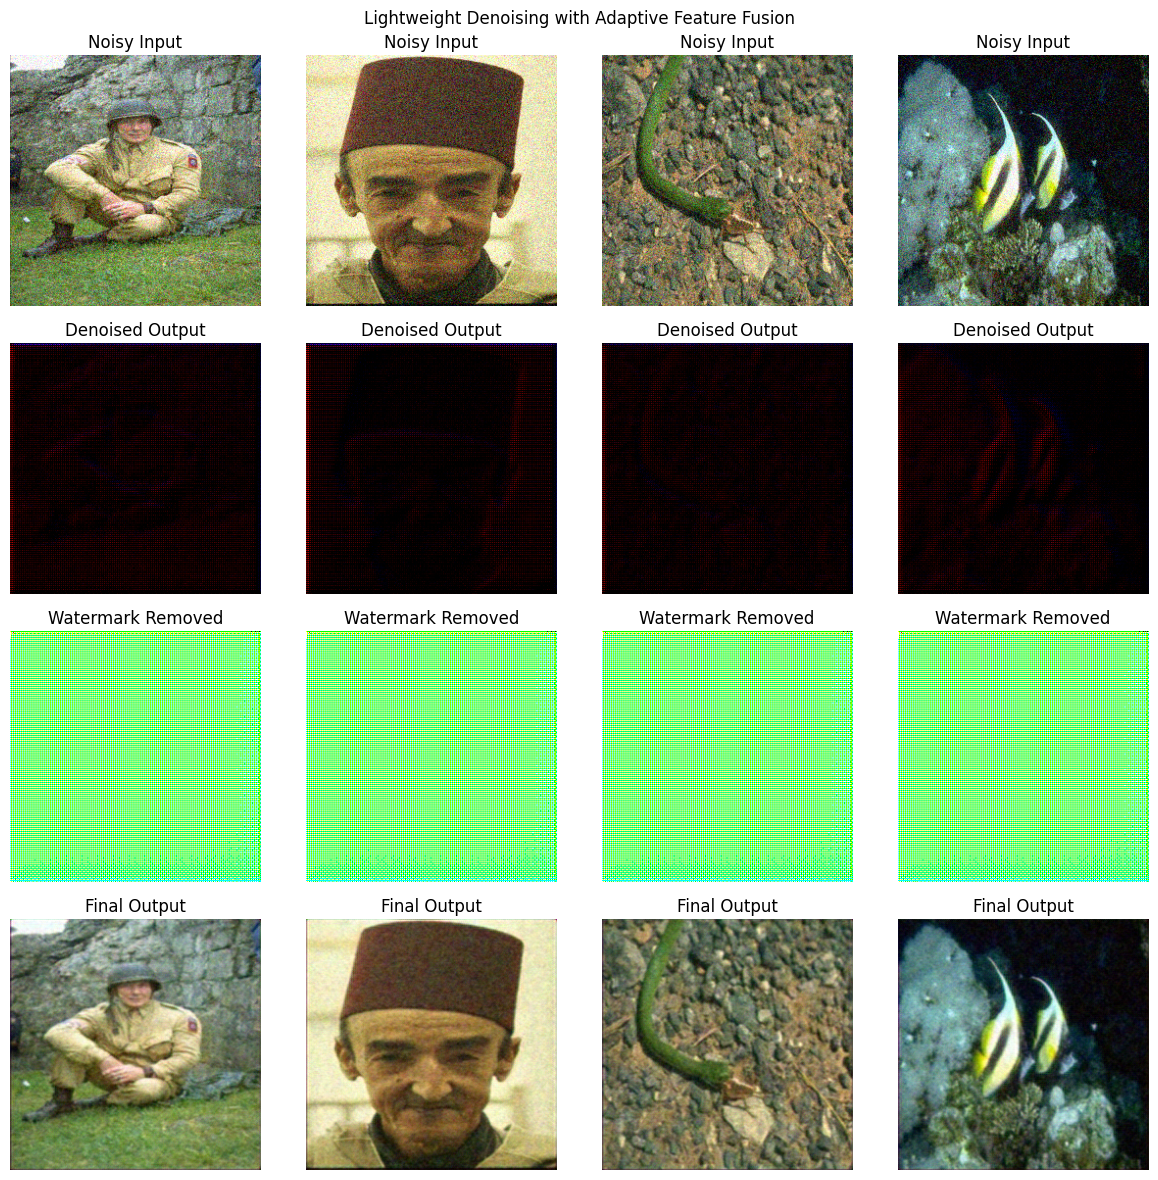

,Metric,Value
0,PSNR,26.6817
1,SSIM,0.7268
2,MSE,0.0023


In [7]:
# Cell 5: Model Evaluation
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch
import matplotlib.pyplot as plt
import pandas as pd

def calculate_metrics(pred, target):
    pred_np = pred.cpu().numpy().transpose(0, 2, 3, 1)  # Shape: (batch, height, width, channels)
    target_np = target.cpu().numpy().transpose(0, 2, 3, 1)
    psnr_vals = []
    ssim_vals = []
    mse_vals = []

    for i in range(pred_np.shape[0]):
        img_shape = pred_np[i].shape
        print(f"Image {i} shape: {img_shape}")
        if img_shape[0] < 7 or img_shape[1] < 7:
            raise ValueError(f"Image {i} too small: {img_shape}. Must be at least 7x7.")

        p = psnr(target_np[i], pred_np[i], data_range=1.0)
        s = ssim(target_np[i], pred_np[i], win_size=7, channel_axis=-1, data_range=1.0)
        m = np.mean((target_np[i] - pred_np[i]) ** 2)
        psnr_vals.append(p)
        ssim_vals.append(s)
        mse_vals.append(m)
    return np.mean(psnr_vals), np.mean(ssim_vals), np.mean(mse_vals)

model.eval()
psnr_scores = []
ssim_scores = []
mse_scores = []

with torch.no_grad():
    for noisy, clean in val_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        main_out, denoise_out, wm_out = model(noisy)
        # Ensure all outputs are in [0, 1]
        main_out = torch.clamp(main_out, 0, 1)
        denoise_out = torch.clamp(denoise_out, 0, 1)
        wm_out = torch.clamp(wm_out, 0, 1)

        # Debug: Check output ranges
        print(f"Main Out Range: {main_out.min().item():.4f} to {main_out.max().item():.4f}")
        print(f"Denoise Out Range: {denoise_out.min().item():.4f} to {denoise_out.max().item():.4f}")
        print(f"Watermark Out Range: {wm_out.min().item():.4f} to {wm_out.max().item():.4f}")

        try:
            p, s, m = calculate_metrics(main_out, clean)
            psnr_scores.append(p)
            ssim_scores.append(s)
            mse_scores.append(m)
        except ValueError as e:
            print(f"Error in metrics calculation: {e}")
            continue

avg_psnr = np.mean(psnr_scores) if psnr_scores else 0
avg_ssim = np.mean(ssim_scores) if ssim_scores else 0
avg_mse = np.mean(mse_scores) if mse_scores else 0

# Visualize sample outputs
noisy, clean = next(iter(val_loader))
noisy, clean = noisy.to(device), clean.to(device)
with torch.no_grad():
    main_out, denoise_out, wm_out = model(noisy)
    main_out = torch.clamp(main_out, 0, 1)
    denoise_out = torch.clamp(denoise_out, 0, 1)
    wm_out = torch.clamp(wm_out, 0, 1)

fig, axes = plt.subplots(5, 4, figsize=(12, 15))
for i in range(4):
    axes[0, i].imshow(noisy[i].cpu().permute(1, 2, 0).numpy())
    axes[0, i].set_title('Noisy Input')
    axes[1, i].imshow(clean[i].cpu().permute(1, 2, 0).numpy())
    axes[1, i].set_title('Ground Truth')
    axes[2, i].imshow(denoise_out[i].cpu().permute(1, 2, 0).numpy())
    axes[2, i].set_title('Denoised Output')
    axes[3, i].imshow(wm_out[i].cpu().permute(1, 2, 0).numpy())
    axes[3, i].set_title('Watermark Removed')
    axes[4, i].imshow(main_out[i].cpu().permute(1, 2, 0).numpy())
    axes[4, i].set_title('Final Output')
    for ax in axes[:, i]:
        ax.axis('off')
plt.suptitle('Lightweight Denoising with Adaptive Feature Fusion')
plt.tight_layout()
plt.show()

# Output: Table of evaluation metrics
data = {
    'Metric': ['PSNR', 'SSIM', 'MSE'],
    'Value': [f'{avg_psnr:.4f}', f'{avg_ssim:.4f}', f'{avg_mse:.4f}']
}
pd.DataFrame(data).style.set_caption("Evaluation Metrics - Lightweight Denoising")